In [1]:
import mlflow
import datetime
import re
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import (
    Input,
    Embedding,
    Dense,
    Concatenate,
    Dropout,
    GlobalAveragePooling2D,
    TextVectorization,
    GlobalAveragePooling1D,
)
from keras import optimizers, metrics, losses, Sequential
from keras.models import Model
from keras.utils import to_categorical
import pandas as pd
import numpy as np
from keras import utils
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

SEED = 123

images_path = "../../data/raw/images/image_train"

In [2]:
def plt_graph(training_history, run=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    range_epochs = np.arange(1, len(training_history.epoch) + 1, 1)

    # Courbe de la précision sur l'échantillon d'entrainement
    ax1.plot(
        range_epochs,
        training_history.history["accuracy"],
        label="Training Accuracy",
        color="blue",
    )

    ax1.plot(
        range_epochs,
        training_history.history["val_accuracy"],
        label="Validation Accuracy",
        color="orange",
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training and Validation Accuracy")
    ax1.legend()

    # Courbe de la précision sur l'échantillon de test
    ax2.plot(
        range_epochs,
        training_history.history["loss"],
        label="Training Loss",
        color="blue",
    )
    ax2.plot(
        range_epochs,
        training_history.history["val_loss"],
        label="Validation Loss",
        color="orange",
    )
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.set_title("Training and Validation Loss")
    ax2.legend()

    if run != None:
        id_exp = str(run.info.run_id)
    else:
        id_exp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Affichage de la figure
    plt.savefig(f"../../reports/figures/{id_exp}_training_history_DNN.png")

In [3]:
df = pd.read_csv("../../data/raw/x_train.csv", index_col=0)
df_target = pd.read_csv("../../data/raw/y_train.csv", index_col=0)
df[df_target.columns[0]] = df_target

df["text"] = np.where(
    df["description"].isna(),
    df["designation"].astype(str),
    df["designation"].astype(str) + " " + df["description"].astype(str),
)

df["image_name"] = df.apply(
    lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1
)
df["image_path"] = images_path + "/" + df["image_name"]

num_classes = df["prdtypecode"].value_counts().shape[0]

# Appliquer des poids aux classes selon l'équilibrage du dataset
class_weights = compute_class_weight(
    class_weight="balanced", classes=df["prdtypecode"].unique(), y=df["prdtypecode"]
)

# Create a dictionary mapping class indices to their corresponding weights
class_weight_dict = dict(zip(df["prdtypecode"].unique(), class_weights))

In [4]:
# 10% for test
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["prdtypecode"].values, random_state=SEED
)
# 5% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["prdtypecode"].values, random_state=SEED
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 72602
Total validation examples: 3822
Total test examples: 8492


In [5]:
def encode_vect(label):
    # Encode
    le = LabelEncoder()
    y_train = le.fit_transform(label)
    # Vectorize
    return to_categorical(y_train, num_classes)


def dataframe_to_dataset(dataframe):
    columns = ["image_path", "text", "prdtypecode"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("prdtypecode")
    labels = encode_vect(labels)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

In [15]:
resize = (299, 299)
sequence_length = 1000


def read_resize(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def custom_standardization(input_data):
    """
    Custom standardization function for text data.

    Args:
        input_data: The input text data.

    Returns:
        The standardized text data.
    """
    decoded_html = tf.strings.unicode_decode(input_data, "UTF-8")
    encoded_html = tf.strings.unicode_encode(decoded_html, "UTF-8")
    stripped_html = tf.strings.regex_replace(encoded_html, "<[^>]*>", " ")
    lowercase = tf.strings.lower(stripped_html)
    cleaned_input_data = tf.strings.regex_replace(lowercase, r"\s+", " ")
    print(cleaned_input_data)
    return tf.strings.regex_replace(
        cleaned_input_data, "[%s]" % re.escape(string.punctuation), ""
    )


vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=100000,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
vectorize_layer.adapt(df["text"])


def preprocess_text(text):
    text = vectorize_layer(text)
    text = tf.convert_to_tensor(text)
    return text


def preprocess(sample):
    image = read_resize(sample["image_path"])
    text = preprocess_text(sample["text"])
    return {"image": image, "text": text}

<tf.RaggedTensor [[b'olivia: personalisiertes notizbuch / 150 seiten / punktraster / ca din a5 / rosen-design'],
 [b"journal des arts (le) n\xc2\xb0 133 du 28/09/2001 - l'art et son marche salon d'art asiatique a paris - jacques barrere - francois perrier - la reforme des ventes aux encheres publiques - le sna fete ses cent ans."],
 [b"grand stylet ergonomique bleu gamepad nintendo wii u - speedlink pilot style pilot style touch pen de marque speedlink est 1 stylet ergonomique pour gamepad nintendo wii u. pour un confort optimal et une pr\xc3\xa9cision maximale sur le gamepad de la wii u: ce grand stylet hautement ergonomique est non seulement parfaitement adapt\xc3\xa9 \xc3\xa0 votre main mais aussi tr\xc3\xa8s \xc3\xa9l\xc3\xa9gant. il est livr\xc3\xa9 avec un support qui se fixe sans adh\xc3\xa9sif \xc3\xa0 l'arri\xc3\xa8re du gamepad caract\xc3\xa9ristiques: mod\xc3\xa8le: speedlink pilot style touch pen couleur: bleu ref. fabricant: sl-3468-be compatibilit\xc3\xa9: gamepad nintend

In [16]:
batch_size = 32 * 2
auto = tf.data.AUTOTUNE


def prepare_dataset(df, training=True):
    ds = dataframe_to_dataset(df)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess(x), y))
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

In [17]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

Tensor("text_vectorization_1_1/StaticRegexReplace_1:0", shape=(), dtype=string)
Tensor("text_vectorization_1_1/StaticRegexReplace_1:0", shape=(), dtype=string)
Tensor("text_vectorization_1_1/StaticRegexReplace_1:0", shape=(), dtype=string)


# Separate the train and test labels for later evaluation.
def separate_labels(ds):
    labels = []
    i = 0
    for _, label in ds.unbatch():
        print("label :", label)
        i += 1
        if i == 5:
            break


train_labels = separate_labels(train_ds)

# Separate the train and test labels for later evaluation.
def separate_labels(ds):
    labels = []
    for _, label in ds.unbatch():
        labels.append(label)
    labels = np.array(labels)
    return labels


train_labels = separate_labels(train_ds)
test_labels = separate_labels(test_ds)

train_labels.shape, test_labels.shape

# Define layers

In [18]:
mlflow.set_tracking_uri("../../mlruns")  # "http://127.0.0.1:8080"
mlflow.set_experiment(experiment_name="Multimodal_DNN_CNN_EFFNETB0_model")
mlflow.tensorflow.autolog(log_datasets=False)

2024/04/30 19:31:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


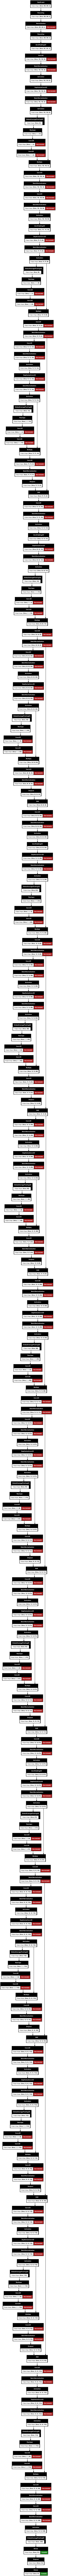

In [19]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(resize[0], resize[1], 3)),
)

# Ajout des couches personnalisées
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024 // 2, activation="relu")(x)
x = Dropout(0.5)(x)  # taux de dropout à 0.5 pour réduire le surapprentissage
predictions = Dense(num_classes, activation="softmax")(
    x
)  # ajustement du nombre de classes selon y_train

model_image = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné pour ne pas les ré-entraîner
for layer in base_model.layers:
    layer.trainable = False

utils.plot_model(model_image, show_shapes=True, show_trainable=True, dpi=60)

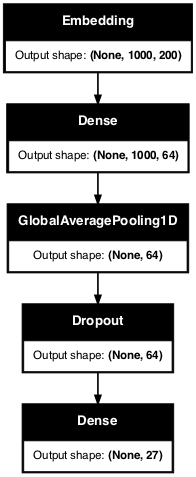

In [20]:
model_text = Sequential(
    [
        Embedding(len(vectorize_layer.get_vocabulary()), 200, mask_zero=True),
        Dense(64, activation="relu"),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

model_text.build((None, sequence_length))
utils.plot_model(model_text, show_shapes=True, dpi=60)

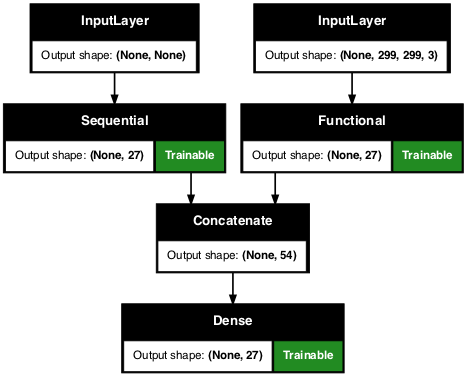

In [21]:
# Define a new input layer for text
text_input = Input(shape=(None,), name="text")

# Define a new input layer for images
image_input = Input(shape=(resize[0], resize[1], 3), name="image")

# Use the text classification model to process the text input
text_output = model_text(text_input)

# Use the image classification model to process the image input
image_output = model_image(image_input)

# Concatenate the output of both models
combined_output = Concatenate()([text_output, image_output])

# Add a new output layer to make the final prediction
output = Dense(num_classes, activation="softmax")(combined_output)

# Define the multimodal model
multimodal_model = Model(inputs=[text_input, image_input], outputs=output)
utils.plot_model(multimodal_model, show_shapes=True, show_trainable=True, dpi=60)

In [22]:
# Compile the model
opt = optimizers.Adam(0.001)
loss = losses.CategoricalCrossentropy()
f1_score = metrics.F1Score(average="weighted")
multimodal_model.compile(
    optimizer=opt,
    loss=loss,
    metrics=["accuracy", f1_score],
)

In [23]:
# Callbacks
early_stopping = EarlyStopping(
    patience=2,  # Attendre n epochs avant application
    min_delta=0.0001,  # si au bout de n epochs la fonction de perte ne varie pas de n %,
    # que ce soit à la hausse ou à la baisse, on arrête
    verbose=1,  # Afficher à quel epoch on s'arrête
    monitor="val_loss",
    start_from_epoch=5,
)
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    patience=2,  # si val_loss stagne sur n epochs consécutives selon la valeur min_delta
    min_delta=0.01,
    factor=0.1,  # On réduit le learning rate d'un facteur n
    cooldown=2,  # On attend n epochs avant de réitérer
    verbose=1,
)

with mlflow.start_run() as run:
    print("Run id:", run.info.run_id)
    # Train the model
    training_history = multimodal_model.fit(
        train_ds,
        epochs=30,
        validation_data=validation_ds,
        callbacks=[reduce_learning_rate, early_stopping],
        class_weight=class_weight_dict,
    )
    plt_graph(training_history, run)

Run id: 4e54ef99ec0c4c98b78914d50e9d01ac


Epoch 1/30
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.2756 - f1_score: 0.1816 - loss: 2.8068

2024/04/30 19:41:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Unable to create dataset (name already exists)


1135/1135 ━━━━━━━━━━━━━━━━━━━━ 621s 541ms/step - accuracy: 0.2757 - f1_score: 0.1817 - loss: 2.8065 - val_accuracy: 0.4757 - val_f1_score: 0.3709 - val_loss: 1.9164 - learning_rate: 0.0010
Epoch 2/30
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.4992 - f1_score: 0.4083 - loss: 1.7874